In [1]:
from dask_jobqueue import SLURMCluster 
from dask.distributed import Client 
  
cluster = SLURMCluster(cores=28,name='make_profiles',walltime='00:30:00',job_extra=['--constraint=HSW24','--exclusive','--nodes=1'],memory='120GB',interface='ib0') 
cluster.scale(136)
cluster

/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 13] Permission denied
  warnings.warn("\n" + msg)


In [2]:
from dask.distributed import Client
client = Client(cluster)
client

Client Scheduler: tcp://172.30.100.1:34589 Dashboard: http://172.30.100.1:41251/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [3]:
!squeue -u albert7a

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           8152954     hsw24 make_pro albert7a PD       0:00      1 (None)
           8152955     hsw24 make_pro albert7a PD       0:00      1 (None)
           8152956     hsw24 make_pro albert7a PD       0:00      1 (None)
           8152957     hsw24 make_pro albert7a PD       0:00      1 (None)
           8152958     hsw24 make_pro albert7a PD       0:00      1 (None)
           8152701     hsw24 make_pro albert7a  R      13:23      1 n2169
           8152702     hsw24 make_pro albert7a  R      13:23      1 n2280
           8152703     hsw24 make_pro albert7a  R      13:23      1 n2281
           8152875     hsw24 make_pro albert7a  R       0:38      1 n2573
           8152876     hsw24 make_pro albert7a  R       0:38      1 n2574
           8152700     hsw24 make_pro albert7a  R      17:03      1 n2801
           8152699     hsw24 make_pro albert7a  R      18:20      1 n2897
           8152874    

In [4]:
import time
nb_workers = 0
while True:
    nb_workers = len(client.scheduler_info()["workers"])
    if nb_workers >= 2:
        break
    time.sleep(1)
print(nb_workers)

135


In [5]:
!squeue -u albert7a

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           8152701     hsw24 make_pro albert7a  R      13:35      1 n2169
           8152702     hsw24 make_pro albert7a  R      13:35      1 n2280
           8152703     hsw24 make_pro albert7a  R      13:35      1 n2281
           8152875     hsw24 make_pro albert7a  R       0:50      1 n2573
           8152876     hsw24 make_pro albert7a  R       0:50      1 n2574
           8152700     hsw24 make_pro albert7a  R      17:15      1 n2801
           8152699     hsw24 make_pro albert7a  R      18:32      1 n2897
           8152874     hsw24 make_pro albert7a  R       1:56      1 n2294
           8152871     hsw24 make_pro albert7a  R       5:40      1 n2160
           8152873     hsw24 make_pro albert7a  R       5:40      1 n2190
           8152954     hsw24 make_pro albert7a  R       0:12      1 n2831
           8152955     hsw24 make_pro albert7a  R       0:12      1 n2833
           8152956     hsw2

In [6]:
import sys
import numpy as np
import numpy.ma as ma
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean
import glob

%matplotlib inline


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/xarray/core/merge.py:16: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [9]:
#params

time_serie_eke=True
time_serie_surf_tke=True
time_serie_0_100m_tke=True


In [10]:
config='EU36'
case='MPC001'
freq='1d'
#year='2010'

datadir='/scratch/cnt0024/hmg2840/colombo/'+str(config)+'/'+str(config)+'-'+str(case)+'-S/'+str(freq)+'/'
#!ls $datadir
gridfile='/scratch/cnt0024/hmg2840/colombo/EU36/EU36-I/coordinates_EU36.nc'
maskfile='/scratch/cnt0024/hmg2840/colombo/EU36/EU36-I/EU36.L75_mesh_mask.nc'

In [11]:
dsgrid=xr.open_dataset(gridfile)
dsmask=xr.open_dataset(maskfile)

In [12]:
def compute_EKE(u,v,u2mean,v2mean):
    ua=0.5*((u2mean-u*u)+(u2mean.shift(x=-1)-u.shift(x=-1)*u.shift(x=-1)))
    va=0.5*((v2mean-v*v)+(v2mean.shift(y=-1)-v.shift(y=-1)*v.shift(y=-1)))
    uat=ua.rename({'depthu':'deptht'})
    vat=va.rename({'depthv':'deptht'})
    eke=0.5*(uat+vat)
    return eke


In [13]:
def compute_TKE(u,v):
    ua=0.5*(u*u+u.shift(x=-1)*u.shift(x=-1))
    va=0.5*(v*v+v.shift(y=-1)*v.shift(y=-1))
    uat=ua.rename({'depthu':'deptht'})
    vat=va.rename({'depthv':'deptht'})
    eke=0.5*(uat+vat)
    return eke


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


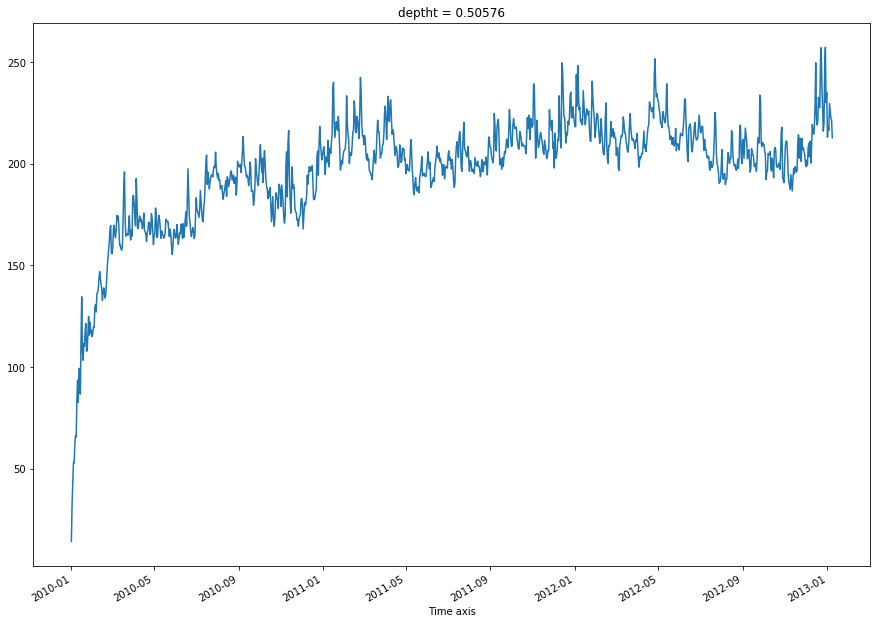

In [14]:
if time_serie_surf_tke==True:
    filesU=sorted(glob.glob(datadir+'*/'+str(config)+'-'+str(case)+'_y????m??d??.'+str(freq)+'_gridU.nc'))
    filesV=sorted(glob.glob(datadir+'*/'+str(config)+'-'+str(case)+'_y????m??d??.'+str(freq)+'_gridV.nc'))
    dsU=xr.open_mfdataset(filesU, chunks={'x':700,'y':1000,'time_counter':1,'depthu':1})
    dsV=xr.open_mfdataset(filesV, chunks={'x':700,'y':1000,'time_counter':1,'depthv':1})
    u=dsU.vozocrtx
    v=dsV.vomecrty
    mask=dsmask.tmask[0]
    tke=compute_TKE(u,v)
    ts0=10000*tke[:,0].mean(dim='x').mean(dim='y')
    fig, ax = plt.subplots(1,1,figsize=(15,10))
    ts0.plot()

In [ ]:
if time_serie_0_100m_tke==True:
    filesU=sorted(glob.glob(datadir+'*/'+str(config)+'-'+str(case)+'_y????m??d??.'+str(freq)+'_gridU.nc'))
    filesV=sorted(glob.glob(datadir+'*/'+str(config)+'-'+str(case)+'_y????m??d??.'+str(freq)+'_gridV.nc'))
    dsU=xr.open_mfdataset(filesU, chunks={'x':700,'y':1000,'time_counter':1,'depthu':1})
    dsV=xr.open_mfdataset(filesV, chunks={'x':700,'y':1000,'time_counter':1,'depthv':1})
    u=dsU.vozocrtx
    v=dsV.vomecrty
    mask=dsmask.tmask[0]
    tke=compute_TKE(u,v)
    ts0=10000*tke.sel(deptht=slice(0,100)).mean(dim='x').mean(dim='y')
    fig, ax = plt.subplots(1,1,figsize=(15,10))
    ts0.plot()